In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import time
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# train中的文件
image_names_train = os.listdir('datasets/train')
print(image_names_train[:5])
print(len(image_names_train))

['dogs', 'cats']
2


In [3]:
assert 'dogs' in image_names_train

In [4]:
image_names_train.remove('dogs')
image_names_train.remove('cats')

In [5]:
print(len(image_names_train))

25000


In [8]:
# 将train中的图像文件移动到dogs or cats对应下的目录中
for image_name in image_names_train:
    src = 'datasets/train/' + image_name
    if image_name[:3] == 'cat':
        dst_cat = 'datasets/train/cats/' + image_name
        shutil.move(src, dst_cat)
    else:
        dst_dog = 'datasets/train/dogs/' + image_name
        shutil.move(src, dst_dog)

In [3]:
assert len(os.listdir('datasets/train')) == 2
assert len(os.listdir('datasets/train/cats')) == 12500
assert len(os.listdir('datasets/train/dogs')) == 12500

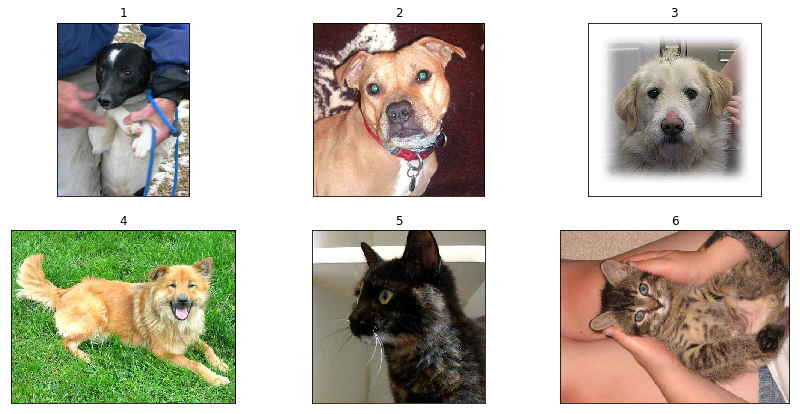

In [4]:
# 图片并列显示
figt = plt.figure(figsize = (14, 7))

for i in range(1, 7):
    ax = figt.add_subplot(2, 3, i, xticks=[], yticks=[])
    img_path = 'datasets/test/test/%d.jpg' % i
    img = image.load_img(img_path)
    ax.set_title(i)
    ax.imshow(img)

plt.show()

In [6]:
# 利用现有模型来预测图片中的类别，排除异常值
# 以cat.15.jpg这张图片作为测试
model = ResNet50(weights='imagenet')

img_path = 'datasets/train/cats/cat.15.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02492035', 'capuchin', 0.42665493), ('n02124075', 'Egyptian_cat', 0.11799844), ('n02119789', 'kit_fox', 0.11399963)]


In [7]:
# 猫狗所属类别对应的编号
dogs = ['n02085620','n02085782','n02085936','n02086079','n02086240','n02086646','n02086910','n02087046',
        'n02087394','n02088094','n02088238','n02088364','n02088466','n02088632','n02089078','n02089867',
        'n02089973','n02090379','n02090622','n02090721','n02091032','n02091134','n02091244','n02091467',
        'n02091635','n02091831','n02092002','n02092339','n02093256','n02093428','n02093647','n02093754',
        'n02093859','n02093991','n02094114','n02094258','n02094433','n02095314','n02095570','n02095889',
        'n02096051','n02096177','n02096294','n02096437','n02096585','n02097047','n02097130','n02097209',
        'n02097298','n02097474','n02097658','n02098105','n02098286','n02098413','n02099267','n02099429',
        'n02099601','n02099712','n02099849','n02100236','n02100583','n02100735','n02100877','n02101006',
        'n02101388','n02101556','n02102040','n02102177','n02102318','n02102480','n02102973','n02104029',
        'n02104365','n02105056','n02105162','n02105251','n02105412','n02105505','n02105641','n02105855',
        'n02106030','n02106166','n02106382','n02106550','n02106662','n02107142','n02107312','n02107574',
        'n02107683','n02107908','n02108000','n02108089','n02108422','n02108551','n02108915','n02109047',
        'n02109525','n02109961','n02110063','n02110185','n02110341','n02110627','n02110806','n02110958',
        'n02111129','n02111277','n02111500','n02111889','n02112018','n02112137','n02112350','n02112706',
        'n02113023','n02113186','n02113624','n02113712','n02113799','n02113978']

cats = ['n02123045','n02123159','n02123394','n02123597','n02124075','n02125311','n02127052']

In [8]:
dogs_cats_idx = dogs + cats

In [9]:
# 预测所属类别，并判断预测的多种类别中是否存在猫狗，若不存在，和为0
preds = model.predict(x)
preds = [tup[0] in dogs_cats_idx for tup in decode_predictions(preds, top=3)[0]]
np.sum(preds)

1

In [10]:
# 异常值监测
def outlier_detect(model, target_size, img_name, top):
    # model : ResNet50(weights='imagenet')
    # target_size : (224, 224)
    # img_name : 'cat.10712.jpg'
    # top : 5(ResNet50 top-5 accuracy)
    img_path = 'datasets/train/' + img_name[:3] + 's/' + img_name
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    preds = [(tup[0] in dogs_cats_idx) for tup in decode_predictions(preds, top=top)[0]]
    return np.sum(preds)

In [11]:
# 样本监测，选取最合适的异常值监测函数的参数：top值
cats_sample_1000 = os.listdir('datasets/train/cats')[:1000]
# len(cats_sample_1000)
dogs_sample_1000 = os.listdir('datasets/train/dogs')[:1000]
# len(dogs_sample_1000)

In [12]:
samples_2000 = cats_sample_1000 + dogs_sample_1000
len(samples_2000)

2000

In [13]:
model_ResNet50 = ResNet50(weights='imagenet')

In [14]:
t0 = time.time()
outlier_image = []
for img_name in samples_2000:
    if not outlier_detect(model_ResNet50, (224, 224), img_name, 10):
        outlier_image.append(img_name)

print("Time: ", time.time() - t0)
print(outlier_image)

Time:  68.30357313156128
['cat.9048.jpg', 'cat.6590.jpg', 'cat.8914.jpg', 'cat.10839.jpg', 'cat.7899.jpg', 'cat.12105.jpg', 'cat.3543.jpg', 'cat.7372.jpg', 'cat.9983.jpg', 'cat.6676.jpg', 'cat.10267.jpg', 'cat.6754.jpg', 'cat.10365.jpg', 'cat.4157.jpg', 'cat.2479.jpg', 'cat.7964.jpg', 'cat.12182.jpg', 'cat.3356.jpg', 'cat.1597.jpg', 'dog.806.jpg', 'dog.11266.jpg', 'dog.1077.jpg', 'dog.1194.jpg', 'dog.1043.jpg', 'dog.1858.jpg', 'dog.3889.jpg']


In [15]:
len(outlier_image)

26

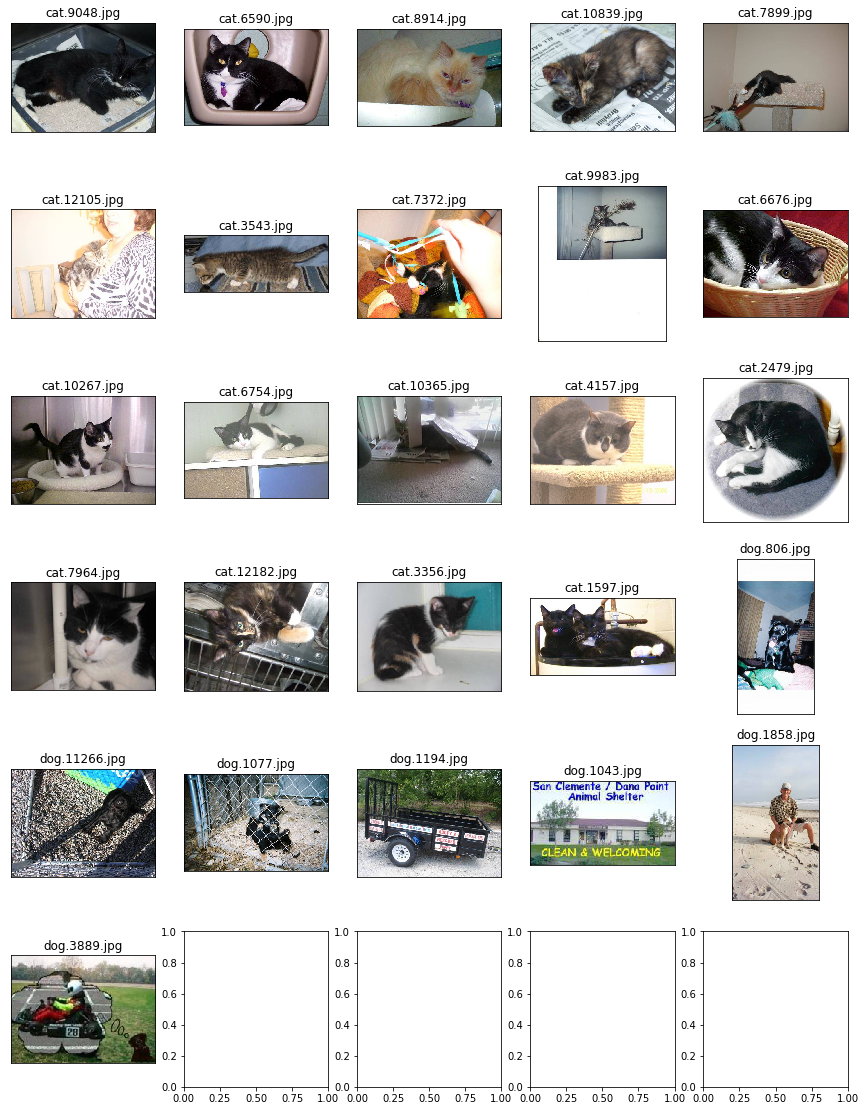

In [20]:
# 图片并列显示
# outlier_image = ['cat.10029.jpg', 'dog.10123.jpg', 'dog.10161.jpg']

fig, axes = plt.subplots(6, 5, sharex=False, sharey=False, figsize = (15,20)) # 6row 5column

for i, ax in enumerate(axes.flatten()):
    if i < 26:
        img_path = 'datasets/train/' + outlier_image[i][:3] + 's/' + outlier_image[i]
        img = image.load_img(img_path)
        ax.set_title(outlier_image[i])
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(img)     

plt.show()


In [21]:
## many pics are cats or dogs , top is small
t0 = time.time()
outlier_image = []
for img_name in samples_2000:
    if not outlier_detect(model_ResNet50, (224, 224), img_name, 50):
        outlier_image.append(img_name)

print("Time: ", time.time() - t0)
print(outlier_image)

Time:  66.64090633392334
['cat.9983.jpg', 'cat.10365.jpg', 'dog.1194.jpg']


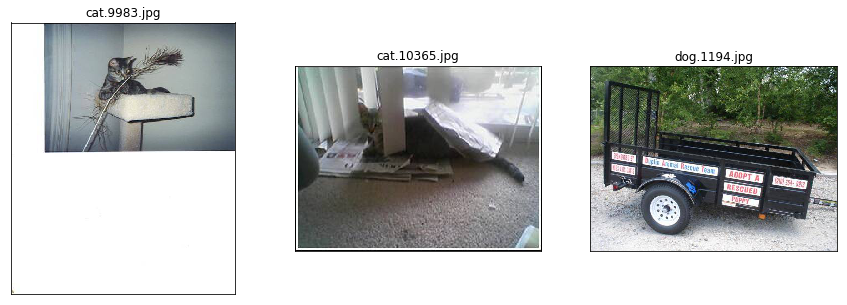

In [22]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False, figsize = (15,5)) # 1row 3column

for i, ax in enumerate(axes.flatten()):
    if i < 26:
        img_path = 'datasets/train/' + outlier_image[i][:3] + 's/' + outlier_image[i]
        img = image.load_img(img_path)
        ax.set_title(outlier_image[i])
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(img)     

plt.show()

In [23]:
## top is too big
t0 = time.time()
outlier_image = []
for img_name in samples_2000:
    if not outlier_detect(model_ResNet50, (224, 224), img_name, 30):
        outlier_image.append(img_name)

print("Time: ", time.time() - t0)
print(outlier_image)

Time:  66.4672360420227
['cat.8914.jpg', 'cat.9983.jpg', 'cat.10365.jpg', 'dog.1194.jpg']


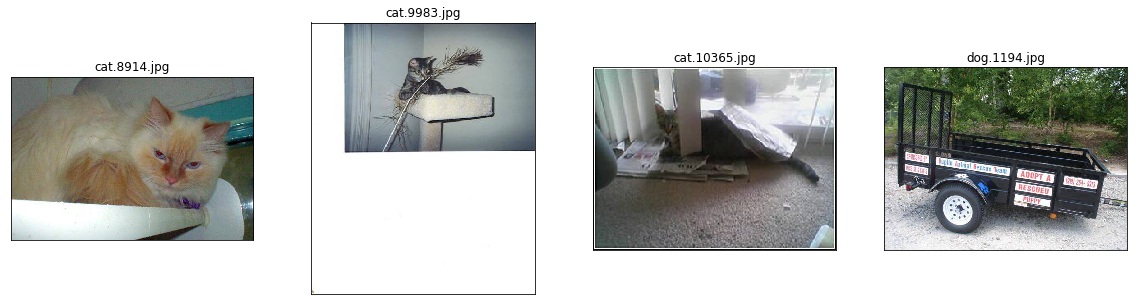

In [24]:
fig, axes = plt.subplots(1, 4, sharex=False, sharey=False, figsize = (20,5)) # 1row 3column

for i, ax in enumerate(axes.flatten()):
    if i < 26:
        img_path = 'datasets/train/' + outlier_image[i][:3] + 's/' + outlier_image[i]
        img = image.load_img(img_path)
        ax.set_title(outlier_image[i])
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(img)     

plt.show()

In [25]:
topbest = 50 # choose 50 

In [26]:
cats_sample = os.listdir('datasets/train/cats')

dogs_sample = os.listdir('datasets/train/dogs')

samples = cats_sample + dogs_sample

len(samples)

25000

In [27]:
t0 = time.time()
outlier_image = []
for img_name in samples:
    if not outlier_detect(model_ResNet50, (224, 224), img_name, topbest):
        outlier_image.append(img_name)

print("Time: ", time.time() - t0)
print(outlier_image)      

Time:  835.8718700408936
['cat.9983.jpg', 'cat.10365.jpg', 'cat.12476.jpg', 'cat.5418.jpg', 'cat.4688.jpg', 'cat.7564.jpg', 'cat.12272.jpg', 'cat.2939.jpg', 'cat.6348.jpg', 'cat.7377.jpg', 'cat.8921.jpg', 'cat.4308.jpg', 'cat.8470.jpg', 'cat.11184.jpg', 'cat.10029.jpg', 'cat.8456.jpg', 'cat.5974.jpg', 'cat.10712.jpg', 'cat.11039.jpg', 'cat.10536.jpg', 'cat.1139.jpg', 'cat.2520.jpg', 'cat.3672.jpg', 'dog.1194.jpg', 'dog.6725.jpg', 'dog.2339.jpg', 'dog.9517.jpg', 'dog.10237.jpg', 'dog.6475.jpg', 'dog.5604.jpg', 'dog.10161.jpg', 'dog.10801.jpg', 'dog.1773.jpg', 'dog.11299.jpg', 'dog.2614.jpg', 'dog.7706.jpg', 'dog.4507.jpg', 'dog.11437.jpg', 'dog.2422.jpg', 'dog.1625.jpg', 'dog.7076.jpg', 'dog.4367.jpg', 'dog.4218.jpg', 'dog.12376.jpg', 'dog.8736.jpg']


In [28]:
len(outlier_image)

45

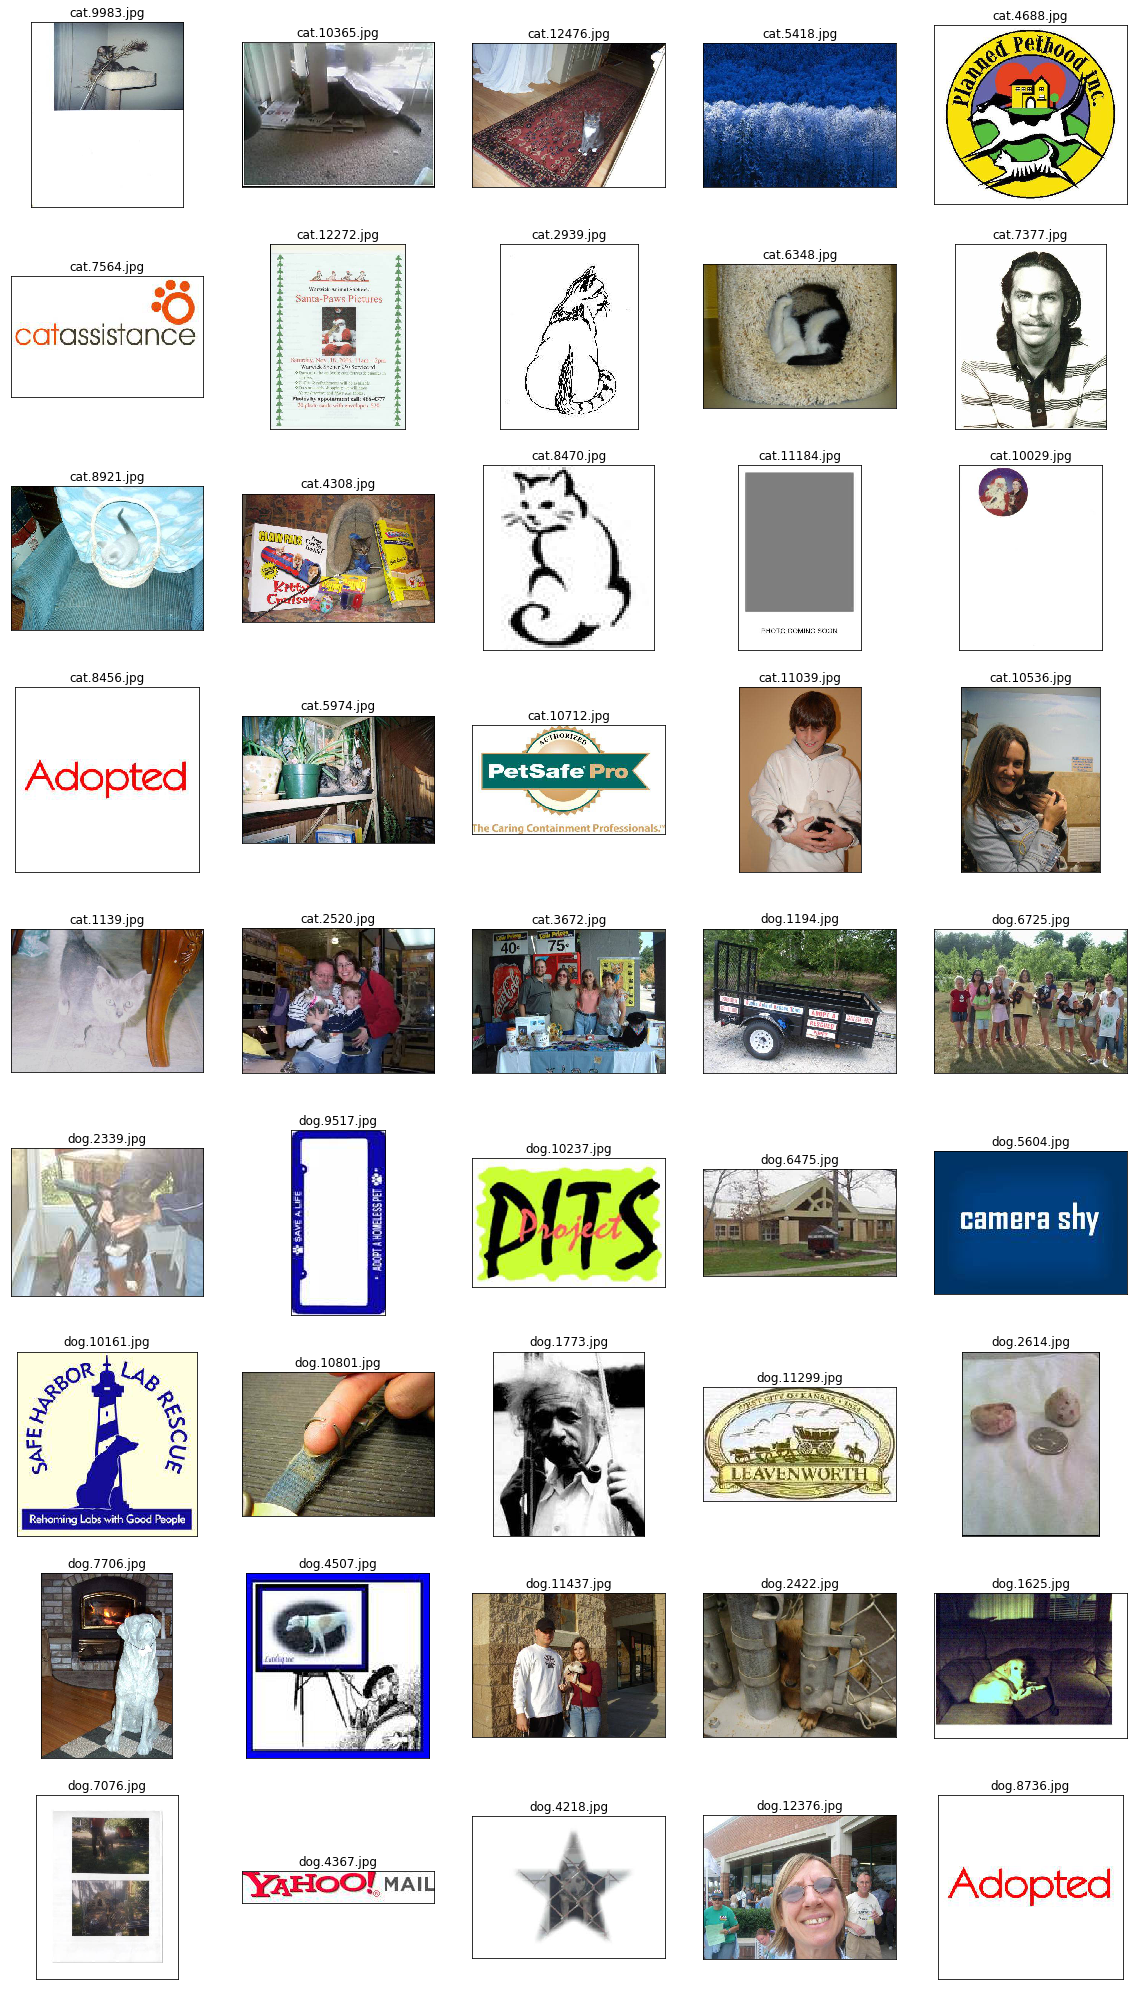

In [31]:
# 图片并列显示

fig, axes = plt.subplots(9, 5, sharex=False, sharey=False, figsize = (20,36)) # 1row 3column

for i, ax in enumerate(axes.flatten()):
    img_path = 'datasets/train/' + outlier_image[i][:3] + 's/' + outlier_image[i]
    img = image.load_img(img_path)
    ax.set_title(outlier_image[i])
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(img)

plt.show()

In [32]:
num_outliers = len(outlier_image)
with open('outliers.txt', 'w') as txtf:
    for i, substr in enumerate(outlier_image, 1):
        txtf.write(substr)
        if i < num_outliers:
            txtf.write(',')

In [33]:
# with open('outliers.txt', 'r') as txtf:
#     lines = txtf.read()
    
# print(lines.split(','))

['cat.9983.jpg', 'cat.10365.jpg', 'cat.12476.jpg', 'cat.5418.jpg', 'cat.4688.jpg', 'cat.7564.jpg', 'cat.12272.jpg', 'cat.2939.jpg', 'cat.6348.jpg', 'cat.7377.jpg', 'cat.8921.jpg', 'cat.4308.jpg', 'cat.8470.jpg', 'cat.11184.jpg', 'cat.10029.jpg', 'cat.8456.jpg', 'cat.5974.jpg', 'cat.10712.jpg', 'cat.11039.jpg', 'cat.10536.jpg', 'cat.1139.jpg', 'cat.2520.jpg', 'cat.3672.jpg', 'dog.1194.jpg', 'dog.6725.jpg', 'dog.2339.jpg', 'dog.9517.jpg', 'dog.10237.jpg', 'dog.6475.jpg', 'dog.5604.jpg', 'dog.10161.jpg', 'dog.10801.jpg', 'dog.1773.jpg', 'dog.11299.jpg', 'dog.2614.jpg', 'dog.7706.jpg', 'dog.4507.jpg', 'dog.11437.jpg', 'dog.2422.jpg', 'dog.1625.jpg', 'dog.7076.jpg', 'dog.4367.jpg', 'dog.4218.jpg', 'dog.12376.jpg', 'dog.8736.jpg']
